# 数値データの特徴量化(二値化/離散化，対数変換，スケーリング/正規化，交互作用特徴量の生成等)について理解する(2022/03/22)
---

## 概要
---
本notebookでは，数値データの特徴量化について学ぶ．扱うものは以下の通り．

- 二値化/離散化
- 対数変換
- スケーリング/正規化
- 交互作用特徴量の生成

それぞれの変換手法の概要と目的について調査した後，Pythonを用いて実装してみる．

## 二値化/離散化
---
二値化とは，その名の通り数値データを$\{0,1\}$の二値に変換することである．

主に画像処理の分野において用いられることが多い．つまり，グレースケールあるいはカラーの画像を完全な白黒画像に変換処理として二値化が用いられている．画像処理において二値化が行われる目的の一つは，物体検出で対象を際立たせる(「エッジを強調する」ともいうらしい)ためである．

画像を二値化する際は，あらかじめ閾値を設定しておき，それより大きいか小さいかによって各ピクセルの階調値を$\{0, 1\}$へ置き換えていく．閾値をどのような値に設定するかについては，様々な手法が考えられている．例えば，変換前の階調値についてピクセル数を度数とするヒストグラムを作成し，分布の「谷」があればその階調値を閾値とする方法などがある．

### 離散化

離散化は二値化の一般化したものだとみなすことができる．閾値をひとつではなく複数設定し，それに応じていくつかの離散値に元の値をマッピングすることによって行われる．画像の場合について極端に言えば，被写体を撮影してデジタルデータになった時点で，RGB階調で離散化が行われていることになる．

以下では，PythonのOpenCVライブラリを用いて二値化を試す．

In [1]:
import cv2

img = cv2.imread("./IMG_0600.JPG", cv2.IMREAD_GRAYSCALE)
img

array([[142, 144, 147, ..., 231, 197, 151],
       [143, 145, 147, ..., 173, 139, 118],
       [146, 147, 147, ...,  40,  49,  56],
       ...,
       [ 79,  80,  83, ...,  95, 221, 200],
       [ 83,  83,  85, ..., 115, 236, 201],
       [ 86,  86,  86, ..., 210, 216, 185]], dtype=uint8)

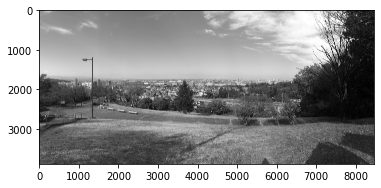

In [2]:
import matplotlib.pyplot as plt

plt.imshow(img, cmap='gray')

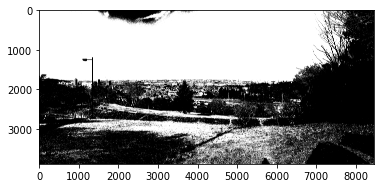

In [3]:
# 二値化
ret, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
plt.imshow(thresh, cmap='gray')

## 対数変換
---

対数変換とはその名の通り，得られたデータを対数値に変換することである．例えば，ある値$a$を対数変換すると$\log{a}$となる．対数の底はネイピア数$e$，ないしは10(常用対数)であることが多い．

対数変換を行う場合として，例えば以下のようなものが挙げられる．

1. 裾の長い，偏った分布を正規分布に近似する場合
1. 回帰分析を行う場合
1. 時系列データの可視化

第一に，裾が長い分布が得られたとき(歪度が大きい正または負の値をとる場合である)，値を対数変換することによって，正規分布の形に近づけることができる．これにより，検定を行う際の検出力の向上などが期待できる．

第二に，回帰分析を行う場合である．例えば単回帰分析において説明変数$x$と目的変数$y$の間に指数的関係性があることが分かっている場合，説明変数$x$を対数変換してから回帰モデルを作成すれば，より精度の高いモデルになる．

第三に，時系列データを可視化する場合である．例えば，時間経過に対して観測値の変化が微小である場合に，そのままグラフに描画するとただの直線に見えてしまうことがある．これを避けるために片対数グラフを作成することで，観測量の増減を把握しやすくすることができる．

対数変換を行うためには，Numpyのlog関数を使えばよいだろう．以下の例では適当なDataFrameを作成してlog関数を適用している．

In [4]:
# DataFrameに複数の要素があると仮定し，そのうちの一つを対数変換する
import pandas as pd
import numpy as np

np.random.seed(0)
columns = ['Column1', 'Column2', 'Column3']
df = pd.DataFrame(np.random.rand(10,3), columns=columns)
df

,Column1,Column2,Column3
0,0.548814,0.715189,0.602763
1,0.544883,0.423655,0.645894
2,0.437587,0.891773,0.963663
3,0.383442,0.791725,0.528895
4,0.568045,0.925597,0.071036
5,0.087129,0.020218,0.832620
6,0.778157,0.870012,0.978618
7,0.799159,0.461479,0.780529
8,0.118274,0.639921,0.143353
9,0.944669,0.521848,0.414662


In [5]:
# 2番目の要素のみ対数変換する
df['Column2'] = df['Column2'].apply(np.log)
df

,Column1,Column2,Column3
0,0.548814,-0.335208,0.602763
1,0.544883,-0.858836,0.645894
2,0.437587,-0.114544,0.963663
3,0.383442,-0.233541,0.528895
4,0.568045,-0.077317,0.071036
5,0.087129,-3.901162,0.832620
6,0.778157,-0.139248,0.978618
7,0.799159,-0.773318,0.780529
8,0.118274,-0.446411,0.143353
9,0.944669,-0.650378,0.414662


## スケーリング(正規化・標準化)
---

スケーリングとは，その名の通りデータのスケール(単位・尺度)を変換することである．

複数の属性を持つデータで，それぞれの属性の単位が異なっていると，当然取りうる値の範囲も異なる．このようなデータに対してスケーリングを行わないと，場合によっては分析結果が特定の属性の影響を強く受ける場合がある．

例えばとあるヒトに関するデータが，「身長(cm)」と「年収(千円)」を属性として持つとする．属性「身長(cm)」はおおよそ100-200の範囲で値を取りうるのに対し，「年収(千円)」はおおよそ0-100000の値を取りうると考えられる．桁が数桁異なるこのような状況では，機械学習モデルに訓練データとして与えた場合に属性「年収(千円)」ばかりを特徴量として過剰に重視するかもしれない．

このような単位尺度による偏りをなくすためにスケーリングは用いられる．スケーリングには主に以下の2種類がある．

- 正規化(Min-Max normalization)
- 標準化(Z-score normalizaiton)

命名に関して若干のブレがあるが，今回は上記カッコ内の手法をそれぞれ正規化・標準化とする．

### 正規化(Min-Max normalization)

### 標準化(Z-score normalization)

## 参考文献
---

[画像の二値化，マクセルフロンティア株式会社](https://www.frontier.maxell.co.jp/blog/posts/3.html)

[二値化処理とは？仕組みやしきい値設定に必要な基礎知識，日本サポートシステム株式会社](https://jss1.jp/column/column_246/)

[2値化，IT用語辞典バイナリ](https://www.sophia-it.com/content/2%E5%80%A4%E5%8C%96)

[2値化 - 画像解析の基本処理、対象を検出する，MiVLog](https://www.mitani-visual.jp/mivlog/imageprocessing/bin03857.php)

[(CMake)WSLに公式OpenCVをやさしくインストール (C/C++, Python2, Python3)，Qiita](https://qiita.com/kekenonono/items/031a3b41d6adb4c3e876)

[matplotlib.pyplot.imshow，matplotlib 3.5.0 documentation](https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.imshow.html)

[Choosing Colormaps in Matplotlib，matplotlib 3.5.1 documentation](https://matplotlib.org/stable/tutorials/colors/colormaps.html)

[画像を扱う，OpenCV-Python Tutorials 1 documentation](http://labs.eecs.tottori-u.ac.jp/sd/Member/oyamada/OpenCV/html/py_tutorials/py_gui/py_image_display/py_image_display.html)

[画像のしきい値処理，OpenCV-Python Tutorials 1 documentation](http://labs.eecs.tottori-u.ac.jp/sd/Member/oyamada/OpenCV/html/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html)

[対数変換とは？対数正規分布や幾何平均についてもわかりやすく解説！，いちばんやさしい、医療統計](https://best-biostatistics.com/summary/log-transformed.html#:~:text=%E5%AF%BE%E6%95%B0%E5%A4%89%E6%8F%9B%E3%81%A8%E3%81%AF%E3%80%81%E3%82%BA%E3%83%90%E3%83%AA,%E3%81%9Flog%E3%81%BE%E3%81%9F%E3%81%AF%E3%80%81ln%E3%81%A7%E3%81%99%E3%80%82&text=log10%3D1%E3%80%81log100%3D2,%E3%81%99%E3%82%8B%E3%81%93%E3%81%A8%E3%81%8C%E3%81%A7%E3%81%8D%E3%81%BE%E3%81%99%E3%80%82)

[対数変換を行う意味について。回帰分析において対数変換する背景にある前提とは？，アタリマエ！](https://atarimae.biz/archives/13161)

[どのようなときに目的変数Yではなくlog(Y)にしたほうがよいのか？～対数変換するメリットとデメリット～，データ化学工学研究室(金子研究室)＠明治大学 理工学部 応用化学科](https://datachemeng.com/post-3529/)

[対数変換について【第51回生物統計学】，ORTHO MEDICO Industry News Topics](https://www.xn--79q34w.com/pdf/20210329.pdf)

[pandas.DataFrame.apply，pandas 1.4.1 documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html)

[numpy.log，Numpy v1.22 Manual](https://numpy.org/doc/stable/reference/generated/numpy.log.html)

[Pythonでのデータ分析:スケーリングを行う，AI人工知能テクノロジー](https://newtechnologylifestyle.net/1363-2/)

[標準化と正規化，AI Academy](https://aiacademy.jp/texts/show/?id=555)

[【Python×データ前処理】正規化・標準化による特徴量スケーリング方法解説・機械学習モデル適用，DXCEL WAVE](https://di-acc2.com/programming/python/3748/)

[正規化（Normalization）／標準化（Standardization）とは？，itmedia](https://atmarkit.itmedia.co.jp/ait/articles/2110/07/news027.html)

[sklearn.preprocessing.MinMaxScaler，scikit-learn 1.0.2 documentaiton](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

[sklearn.preprocessing.StandardScaler，scikit-learn 1.0.2 documentaiton](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)